# Sample design: stratified random sample

In [1]:
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
import shapely
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
import geopandas as gpd
import xarray as xr

from sklearn import cluster
from sklearn import neighbors
from sklearn import mixture

/Users/etriesch/.pyenv/versions/3.9.5/envs/venv.ocean-carbon-sampling/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

## Read in temp and color data

In [3]:
repo_path = Path('/Users/etriesch/dev/ocean-carbon-sampling/')
data_clean_path = repo_path / 'data/clean/'
data_raw_path = repo_path / 'data/raw/'
geo_crs = 'epsg:4326'
proj_crs = '+proj=cea'

In [4]:
# read data
t_raw = pd.read_csv(data_clean_path / 'sst.csv')
c_raw = pd.read_csv(data_clean_path / 'chlor_a.csv')
# c_ann_raw = pd.read_csv(data_clean_path / 'chlor_a_annual.csv')

In [5]:
# merge on x/y values
m = pd.merge(left=c_raw, right=t_raw, how='inner', on=['x', 'y'], suffixes=('_c', '_t'))

In [6]:
# make geodataframe
geo = [Point(lon, lat) for lat, lon in zip(m.lat_c, m.lon_c)]
geo_m = gpd.GeoDataFrame(m, geometry=geo, crs=geo_crs)

## Subset to sample zones

In [7]:
# load coastlines (saved locally)
boundary_fp = data_raw_path / 'stanford-vg541kt0643-shapefile.zip'
boundary = gpd.read_file(data_raw_path / boundary_fp).to_crs(geo_crs)

In [8]:
# Monterrey desal mask
ca_cent = [-121.788649, 36.802834]
ca_lats = [33.48, 39.48]
ca_lons = [-125.48, -119.48]
# Texas desal mask
tx_cent = [-95.311296, 28.927239]
tx_lats = [25.57, 31.57]
tx_lons = [-98.21, -92.21]
# NH desal mask
nh_cent = [-70.799678, 42.563588]
nh_lats = [39.38, 45.38]
nh_lons = [-73.50, -67.50]

In [9]:
# make disks
BUFFER = 1.5
ca_disc = gpd.GeoSeries(Point(ca_cent), crs=proj_crs).buffer(BUFFER).set_crs(geo_crs, allow_override=True)
ca_disc = gpd.GeoDataFrame(geometry=ca_disc)
tx_disc = gpd.GeoSeries(Point(tx_cent), crs=proj_crs).buffer(BUFFER).set_crs(geo_crs, allow_override=True)
tx_disc = gpd.GeoDataFrame(geometry=tx_disc)
nh_disc = gpd.GeoSeries(Point(nh_cent), crs=proj_crs).buffer(BUFFER).set_crs(geo_crs, allow_override=True)
nh_disc = gpd.GeoDataFrame(geometry=nh_disc)
# cut discs at coastal boundary
ca = ca_disc.overlay(boundary, how='difference')
tx = tx_disc.overlay(boundary, how='difference')
nh = nh_disc.overlay(boundary, how='difference')

In [10]:
# make sample zones
pac_sample = geo_m.overlay(ca, how='intersection')
atl_sample = geo_m.overlay(nh, how='intersection')
gul_sample = geo_m.overlay(tx, how='intersection')

In [63]:
# make tuples of sample zones, discs, and desalination plant locations
PAC = [pac_sample, ca, ca_cent] # pacific
ATL = [atl_sample, nh, nh_cent] # atlantic
GUL = [gul_sample, tx, tx_cent] # gulf

sample_locations = [pac_sample, atl_sample, gul_sample]

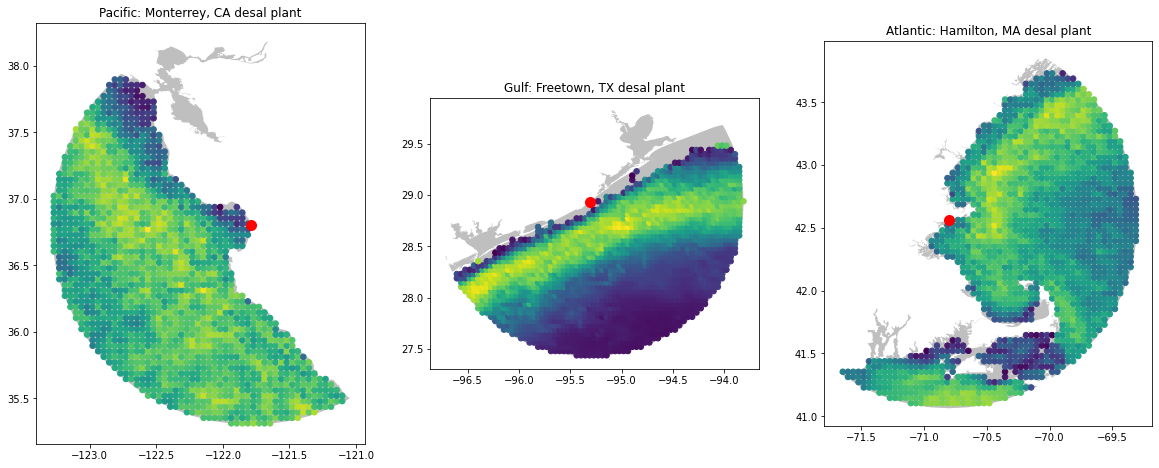

In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,20))

# pacific
PAC[1].plot(ax=ax1, alpha=0.5, color='gray')
PAC[0].plot(ax=ax1, column='std_c', markersize=30)
gpd.GeoSeries(Point(PAC[2])).plot(ax=ax1, color='r', markersize=100)
ax1.set_title('Pacific: Monterrey, CA desal plant')
# gulf
GUL[1].plot(ax=ax2, alpha=0.5, color='gray')
GUL[0].plot(ax=ax2, column='std_c', markersize=30)
gpd.GeoSeries(Point(GUL[2])).plot(ax=ax2, color='r', markersize=100)
ax2.set_title('Gulf: Freetown, TX desal plant')
# atlantic
ATL[1].plot(ax=ax3, alpha=0.5, color='gray')
ATL[0].plot(ax=ax3, column='std_c', markersize=30)
gpd.GeoSeries(Point(ATL[2])).plot(ax=ax3, color='r', markersize=100)
ax3.set_title('Atlantic: Hamilton, MA desal plant')

plt.show()

# Generate strata through clustering

In [65]:
def get_cluster_ids(df, var, cluster_method, kw):
    cl = cluster_method.set_params(**kw)
    cl.fit(df[var])
    return cl.labels_

In [66]:
# get kmeans clusters
CLUSTERS = 6
kw = {'n_clusters':CLUSTERS}
cluster_vars = ['lat_c', 'lon_c']
for s in sample_locations:
    s['kmeans_cluster'] = get_cluster_ids(s, cluster_vars, cluster.KMeans(), kw)

In [67]:
# get agglomerative clusters
CLUSTERS = 6
cluster_vars = ['lat_c', 'lon_c', 'mean_t', 'std_c', 'months_below_mean']

for s in sample_locations:
    cmap = neighbors.kneighbors_graph(s[['lat_c', 'lon_c']].values, n_neighbors=6, mode='connectivity', include_self=True)
    kw = {'n_clusters':CLUSTERS, 'connectivity':cmap, 'linkage':'ward'}
    s['agg_cluster'] = get_cluster_ids(s, cluster_vars, cluster.AgglomerativeClustering(), kw)

In [74]:
# get gaussian mixture clusters
CLUSTERS = 6
cluster_vars = ['lat_c', 'lon_c', 'mean_t', 'std_c', 'months_below_mean']

for s in sample_locations:
    cmap = neighbors.kneighbors_graph(s[['lat_c', 'lon_c']].values, n_neighbors=6, mode='connectivity', include_self=True)
    cl = mixture.GaussianMixture(n_components=CLUSTERS, random_state=1234)
    s['gaus_cluster'] = cl.fit_predict(s[cluster_vars])

In [75]:
# set params
df, sample_zone, desal = GUL

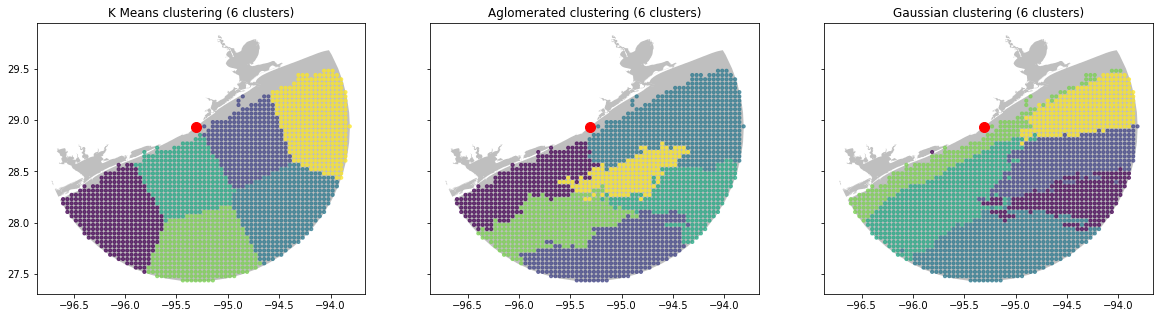

In [76]:
# plot clusters with raster data
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,20), sharey=True)
# kmeans
sample_zone.plot(ax=ax1, alpha=0.5, color='gray')
df.plot(ax=ax1, column='kmeans_cluster', alpha=0.7, markersize=10)
gpd.GeoSeries(Point(desal)).plot(ax=ax1, color='r', markersize=100)
ax1.set_title(f'K Means clustering ({CLUSTERS} clusters)')

# agg cluster
sample_zone.plot(ax=ax2, alpha=0.5, color='gray')
df.plot(ax=ax2, column='agg_cluster', alpha=0.7, markersize=10)
gpd.GeoSeries(Point(desal)).plot(ax=ax2, color='r', markersize=100)
ax2.set_title(f'Aglomerated clustering ({CLUSTERS} clusters)')

# ward cluster
sample_zone.plot(ax=ax3, alpha=0.5, color='gray')
df.plot(ax=ax3, column='gaus_cluster', alpha=0.7, markersize=10)
gpd.GeoSeries(Point(desal)).plot(ax=ax3, color='r', markersize=100)
ax3.set_title(f'Gaussian clustering ({CLUSTERS} clusters)')

plt.show()

## Turn raster strata into polygons

In [77]:
def make_polygons_from_points(df, cluster_col, buffer=0.042):
    strata = []
    clusters = df[cluster_col].drop_duplicates().sort_values().values
    #loop through clusters
    for c in clusters:
        # turn cluster points into polygon
        clust = df.loc[df[cluster_col] == c]
        clust = Polygon(MultiPoint(clust.geometry.values)
                 .buffer(buffer, cap_style=shapely.geometry.CAP_STYLE.square, join_style=shapely.geometry.JOIN_STYLE.mitre
                        ))
        clust = gpd.GeoDataFrame(geometry=gpd.GeoSeries(clust, crs=geo_crs))
        # clip from each of the existing strata
        for s in strata:
            clust = clust.overlay(gpd.GeoDataFrame(geometry=gpd.GeoSeries(s, crs=geo_crs)), how='difference')
        strata += [clust.values[0][0]]
    # turn to dataframe
    strata_gdf = gpd.GeoDataFrame(pd.DataFrame({'strata':clusters}), geometry=strata, crs=geo_crs).overlay(boundary, how='difference')
    return strata_gdf

In [79]:
# get kmeans agg, and gaus strata for each coast
pac_strata_kmeans = make_polygons_from_points(PAC[0], 'kmeans_cluster', buffer=0.042)
pac_strata_agg = make_polygons_from_points(PAC[0], 'agg_cluster', buffer=0.021)
pac_strata_gaus = make_polygons_from_points(PAC[0], 'gaus_cluster', buffer=0.2)

atl_strata_kmeans = make_polygons_from_points(ATL[0], 'kmeans_cluster', buffer=0.042)
atl_strata_agg = make_polygons_from_points(ATL[0], 'agg_cluster', buffer=0.021)
atl_strata_gaus = make_polygons_from_points(ATL[0], 'gaus_cluster', buffer=0.106)

gul_strata_kmeans = make_polygons_from_points(GUL[0], 'kmeans_cluster', buffer=0.042)
gul_strata_agg = make_polygons_from_points(GUL[0], 'agg_cluster', buffer=0.021)
gul_strata_gaus = make_polygons_from_points(GUL[0], 'gaus_cluster', buffer=0.2)

/Users/etriesch/.pyenv/versions/3.9.5/envs/venv.ocean-carbon-sampling/lib/python3.9/site-packages/shapely/geometry/polygon.py:539: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  ret = geos_linearring_from_py(shell)
/Users/etriesch/.pyenv/versions/3.9.5/envs/venv.ocean-carbon-sampling/lib/python3.9/site-packages/shapely/geometry/polygon.py:539: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  ret = geos_linearring_from_py(shell)


TypeError: object of type 'Polygon' has no len()

In [54]:
# add to feature lists
PAC += [pac_strata_kmeans, pac_strata_agg, pac_strata_gaus]
ATL += [atl_strata_kmeans, atl_strata_agg, atl_strata_gaus]
GUL += [gul_strata_kmeans, gul_strata_agg, gul_strata_gaus]

## Generate samples within each strata

In [55]:
def rejection_sample(n, region):
    # get fraction of sampling area
    sample_area = region.to_crs(proj_crs).area.values
    total_area = (gpd.GeoDataFrame(
            geometry=gpd.GeoSeries(
                Polygon([Point([region.bounds.minx, region.bounds.miny]), Point([region.bounds.minx, region.bounds.maxy]), 
                         Point([region.bounds.maxx, region.bounds.miny]), Point([region.bounds.maxx, region.bounds.maxy])]),
                crs=geo_crs).envelope).to_crs(proj_crs).area).values
    pct_sample_area = sample_area / total_area
    
    # scale up target sample size to account for this
    n_scale = (np.ceil(n / pct_sample_area)).astype(int)
    
    # generate lat lons
    lon = np.random.uniform(region.bounds.minx, region.bounds.maxx, n_scale)
    lat = np.random.uniform(region.bounds.miny, region.bounds.maxy, n_scale)
    geo = [Point(lat, lon) for lat, lon in zip(lon, lat)]
    geo_sub = [pt for pt in geo if region.contains(pt).values]
#     print(f'Targeted {n} samples, {len(geo_sub)} returned ({len(geo_sub)-n})')
    
    return gpd.GeoSeries(geo_sub, crs=region.crs)

In [56]:
def stratified_sample(n, stratified_region):
    area = stratified_region.to_crs(proj_crs).area
    area = area / area.sum()
    strata_samples = np.ceil(area * n)

    # get sample points per region
    sample_points = {}
    for c in strata_samples.index:
        sub = stratified_region.loc[stratified_region.strata == c, 'geometry']
        sub = rejection_sample(strata_samples.loc[c], sub).values
        sample_points[c] = sub
    
    # convert to dataframe
    sample_points = pd.concat(pd.DataFrame({'strata':k, 'geometry':v}) for k, v in sample_points.items())
    sample_points = gpd.GeoDataFrame(sample_points)
    return(sample_points)

In [57]:
# generate stratified samples
SAMPLES = 200
pac_kmeans_samples = stratified_sample(SAMPLES, PAC[3])
pac_agg_samples = stratified_sample(SAMPLES, PAC[4])
pac_gaus_samples = stratified_sample(SAMPLES, PAC[5])
atl_kmeans_samples = stratified_sample(SAMPLES, ATL[3])
atl_agg_samples = stratified_sample(SAMPLES, ATL[4])
atl_gaus_samples = stratified_sample(SAMPLES, ATL[5])
gul_kmeans_samples = stratified_sample(SAMPLES, GUL[3])
gul_agg_samples = stratified_sample(SAMPLES, GUL[4])
gul_gaus_samples = stratified_sample(SAMPLES, GUL[5])

In [58]:
# add to feature lists
PAC += [pac_kmeans_samples, pac_agg_samples, pac_gaus_samples]
ATL += [atl_kmeans_samples, atl_agg_samples, atl_gaus_samples]
GUL += [gul_kmeans_samples, gul_agg_samples, gul_gaus_samples]

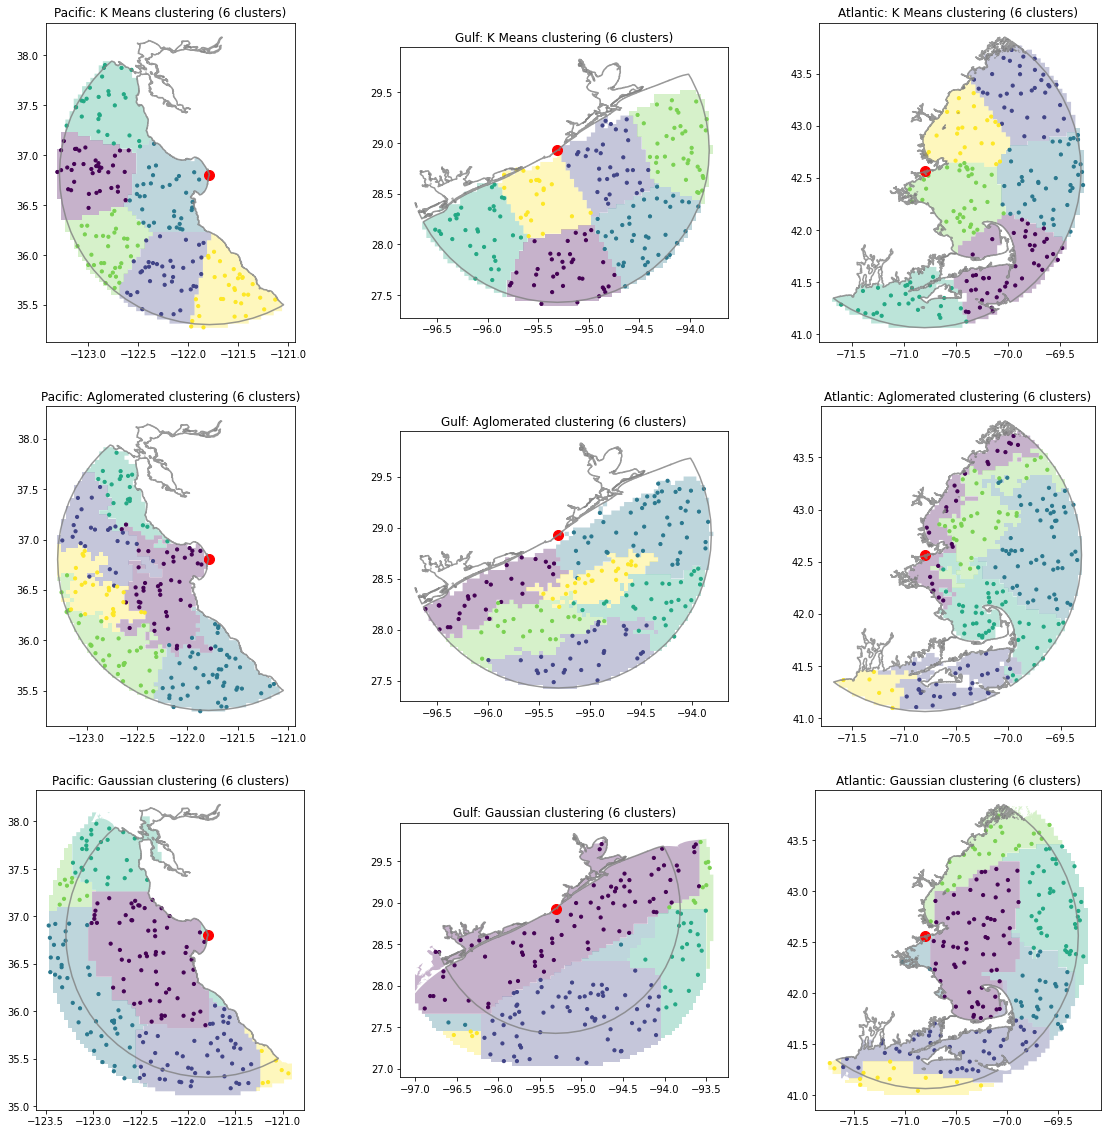

In [59]:
# plot clusters with polygons
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20,20))

# PACIFIC
# kmeans
PAC[1].boundary.plot(ax=ax[0,0], alpha=0.8, color='gray') # background
PAC[3].plot(ax=ax[0,0], column='strata', alpha=0.3) # strata
PAC[6].plot(ax=ax[0,0], column='strata', markersize=10) # sample points
gpd.GeoSeries(Point(PAC[2])).plot(ax=ax[0,0], color='r', markersize=100) # desalination plant
ax[0,0].set_title(f'Pacific: K Means clustering ({CLUSTERS} clusters)') #title

# agg cluster
PAC[1].boundary.plot(ax=ax[1,0], alpha=0.8, color='gray')
PAC[4].plot(ax=ax[1,0], column='strata', alpha=0.3)
PAC[7].plot(ax=ax[1,0], column='strata', markersize=10) # sample points
gpd.GeoSeries(Point(PAC[2])).plot(ax=ax[1,0], color='r', markersize=100)
ax[1,0].set_title(f'Pacific: Aglomerated clustering ({CLUSTERS} clusters)')

# gauss cluster
PAC[1].boundary.plot(ax=ax[2,0], alpha=0.8, color='gray')
PAC[5].plot(ax=ax[2,0], column='strata', alpha=0.3)
PAC[8].plot(ax=ax[2,0], column='strata', markersize=10) # sample points
gpd.GeoSeries(Point(PAC[2])).plot(ax=ax[2,0], color='r', markersize=100)
ax[2,0].set_title(f'Pacific: Gaussian clustering ({CLUSTERS} clusters)')

# GULF
# kmeans
GUL[1].boundary.plot(ax=ax[0,1], alpha=0.8, color='gray')
GUL[3].plot(ax=ax[0,1], column='strata', alpha=0.3)
GUL[6].plot(ax=ax[0,1], column='strata', markersize=10) # sample points
gpd.GeoSeries(Point(GUL[2])).plot(ax=ax[0,1], color='r', markersize=100)
ax[0,1].set_title(f'Gulf: K Means clustering ({CLUSTERS} clusters)')

# agg cluster
GUL[1].boundary.plot(ax=ax[1,1], alpha=0.8, color='gray')
GUL[4].plot(ax=ax[1,1], column='strata', alpha=0.3)
GUL[7].plot(ax=ax[1,1], column='strata', markersize=10) # sample points
gpd.GeoSeries(Point(GUL[2])).plot(ax=ax[1,1], color='r', markersize=100)
ax[1,1].set_title(f'Gulf: Aglomerated clustering ({CLUSTERS} clusters)')

# gaus cluster
GUL[1].boundary.plot(ax=ax[2,1], alpha=0.8, color='gray')
GUL[5].plot(ax=ax[2,1], column='strata', alpha=0.3)
GUL[8].plot(ax=ax[2,1], column='strata', markersize=10) # sample points
gpd.GeoSeries(Point(GUL[2])).plot(ax=ax[2,1], color='r', markersize=100)
ax[2,1].set_title(f'Gulf: Gaussian clustering ({CLUSTERS} clusters)')

# ATLANTIC
# kmeans
ATL[1].boundary.plot(ax=ax[0,2], alpha=0.8, color='gray')
ATL[3].plot(ax=ax[0,2], column='strata', alpha=0.3)
ATL[6].plot(ax=ax[0,2], column='strata', markersize=10) # sample points
gpd.GeoSeries(Point(ATL[2])).plot(ax=ax[0,2], color='r', markersize=100)
ax[0,2].set_title(f'Atlantic: K Means clustering ({CLUSTERS} clusters)')

# agg cluster
ATL[1].boundary.plot(ax=ax[1,2], alpha=0.8, color='gray')
ATL[4].plot(ax=ax[1,2], column='strata', alpha=0.3)
ATL[7].plot(ax=ax[1,2], column='strata', markersize=10) # sample points
gpd.GeoSeries(Point(ATL[2])).plot(ax=ax[1,2], color='r', markersize=100)
ax[1,2].set_title(f'Atlantic: Aglomerated clustering ({CLUSTERS} clusters)')

# gaus cluster
ATL[1].boundary.plot(ax=ax[2,2], alpha=0.8, color='gray')
ATL[5].plot(ax=ax[2,2], column='strata', alpha=0.3)
ATL[8].plot(ax=ax[2,2], column='strata', markersize=10) # sample points
gpd.GeoSeries(Point(ATL[2])).plot(ax=ax[2,2], color='r', markersize=100)
ax[2,2].set_title(f'Atlantic: Gaussian clustering ({CLUSTERS} clusters)')

plt.show()